<a href="https://colab.research.google.com/github/saquibali7/VideoFramePrediction/blob/main/FramePrediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import pickle
import numpy as np
from numpy import load
from numpy import savez_compressed
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q git+https://github.com/tensorflow/docs
import imageio
from tensorflow_docs.vis import embed
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

  Preparing metadata (setup.py) ... done


In [4]:
data_path = '/content/drive/MyDrive/t2_Videos_GAN'
data = os.listdir(data_path)

In [5]:
len(data)

792

In [11]:
def return_frames(idx):
  frames=list()
  cap = cv2.VideoCapture(os.path.join(data_path,data[idx]))
  while(cap.isOpened()):
    ret, frame = cap.read()
    try:
      img = cv2.resize(frame, (256, 256))
      frames.append(img)
    except:
      break
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break   
  frames = np.array(frames)  
  cap.release()
  cv2.destroyAllWindows()
  return frames


In [ ]:
image = list()
for i in range(300):
  count = 0
  cap= cv2.VideoCapture(os.path.join(data_path,data[i]))
  temp = []
  while(cap.isOpened()):
    ret, frame = cap.read()
    count+=1
    try:
      img = cv2.resize(frame, (256,256))
      temp.append(img)
    except:
      break
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  count=0
  while(count+10 <= len(temp)):
    image.append(temp[count:count+10])
    count = count+10
  
  cap.release()
  cv2.destroyAllWindows()    


In [ ]:
image = np.array(image)
print(image.shape)

(998, 10, 256, 256, 3)



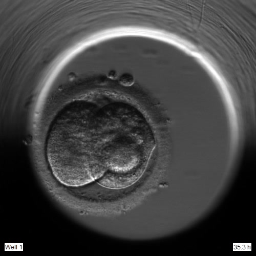

In [ ]:
idx = np.random.randint(0,len(image))
to_gif(image[idx]/255.0)

In [ ]:
%cd /content/drive/MyDrive/framePrediction

/content/drive/MyDrive/framePrediction


In [ ]:
indexes = np.arange(image.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * image.shape[0])]
val_index = indexes[int(0.9 * image.shape[0]) :]
train_dataset = image[train_index]
val_dataset = image[val_index]

In [ ]:
train_dataset= (train_dataset/255.0).astype(np.float16)
val_dataset= (val_dataset/255.0).astype(np.float16)


In [ ]:
def create_dataset(frames):
  x = frames[:, 0:frames.shape[1]-1, :, :]
  y = frames[: , 1:frames.shape[1], :, :]
  return x, y

In [ ]:
train_x, train_y = create_dataset(train_dataset)
val_x, val_y = create_dataset(val_dataset)

In [ ]:
print(train_x.shape, train_y.shape)
print(val_x.shape,val_y.shape)

(898, 9, 256, 256, 3) (898, 9, 256, 256, 3)
(100, 9, 256, 256, 3) (100, 9, 256, 256, 3)


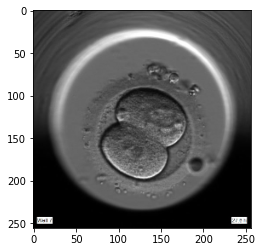

In [ ]:
plt.imshow(train_x[0][0].astype(np.float32))

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
input = layers.Input(shape=(None, *train_x.shape[2:]))
x = layers.ConvLSTM2D(
    filters = 64, 
    kernel_size=(5,5),
    padding="same",
    return_sequences=True,    
    activation="relu"
    )(input)

x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 64,
    kernel_size=(3,3),
    padding = "same",
    return_sequences = True,
    activation = "relu"
    )(x)

x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 64,
    kernel_size=(3,3),
    padding = "same",
    return_sequences = True,
    activation = "relu"
    )(x)

x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 64,
    kernel_size = (1,1),
    padding = "same",
    return_sequences = True,
    activation = "relu"
    )(x)

x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 64,
    kernel_size = (1,1),
    padding = "same",
    return_sequences = True,
    activation = "relu"
    )(x)    

x = layers.Conv3D(
    filters = 3, 
    kernel_size = (3, 3, 3),
    activation = "sigmoid",
    padding = "same"
    )(x)

model = keras.models.Model(input, x)
model.compile(
    loss=keras.losses.binary_crossentropy,
  optimizer=keras.optimizers.Adam(),
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 256, 256,   0         
                             3)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 256, 256, 6  429056    
                             4)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 256, 256, 6  256      
 ormalization)               4)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 256, 256, 6  295168    
                             4)                                  
                                                                 
 batch_normalization_1 (Batc  (None, None, 256, 256, 6  256  

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience = 5)

In [ ]:
# epochs = 30
# batch_size = 2

# model.fit(
#     train_x,
#     train_y,
#     batch_size = batch_size,
#     epochs = epochs,
#     validation_data = (val_x, val_y),
#     callbacks = [early_stopping, reduce_lr])

In [ ]:
# model.save('/content/drive/MyDrive/framePrediction/model_xy301_256_10_2_1')

In [16]:
load_model = tf.keras.models.load_model('/content/drive/MyDrive/framePrediction/model_xy301_256_10_2_1')

In [17]:
import random

def random_frames(idx):
  image = list()
  cap= cv2.VideoCapture(os.path.join(data_path,data[idx]))
  temp = []
  while(cap.isOpened()):
    ret, frame = cap.read()
    try:
      img = cv2.resize(frame, (256,256))
      image.append(img)
    except:
      break
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break
  
  cap.release()
  cv2.destroyAllWindows()  
  return np.array(image)

In [18]:
import random
import matplotlib.pyplot as plt
from math import log10, sqrt
from tqdm import tqdm


def PSNR(expected,Predicted): 
    mse = np.mean((expected - Predicted) ** 2) 
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return mse,psnr

In [20]:
def generate_images(frames):
  # idx = random.randint(0,len(val_x))
  expected = frames[-1]/255.0
  frames = frames[0:9, :, :, :]/255.0
  
  out = load_model.predict(np.expand_dims(frames, axis = 0))
  out = np.squeeze(out, axis = 0)
  out = np.expand_dims(out[-1, ...], axis = 0)
  out = tf.squeeze(out,axis = 0)
  expected = expected.astype(np.float32)

  plt.figure(figsize=(15,15))
  title = ['Ground Truth','Predicted']
  display_list = [expected,out]
  for i in range(2):
        plt.subplot(1,2,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')

  plt.show()
  mse,psnr = PSNR(expected*255,out*255)
  print("MSE value is {}".format(mse))
  print("PNSR value is {}".format(psnr))
  expected = expected.astype(np.float32)
  ssim = tf.image.ssim(expected, out, max_val=1, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
  print("SSIM value is {}".format(ssim))

1/1 [==============================] - 14s 14s/step


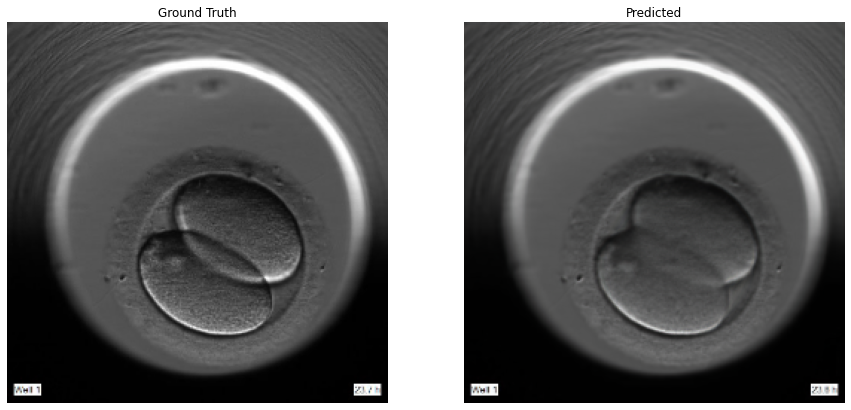

MSE value is 46.94606399536133
PNSR value is 31.41481174420234
SSIM value is 0.9072509407997131


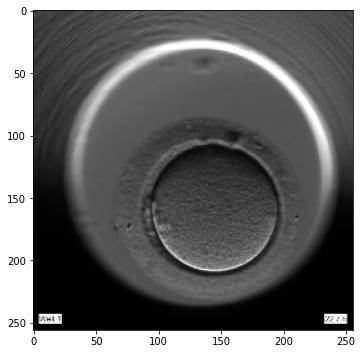

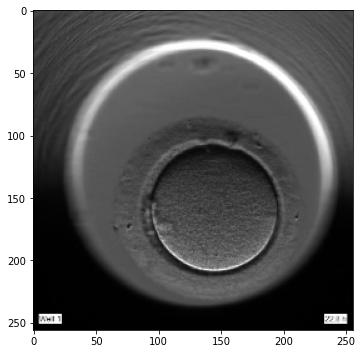

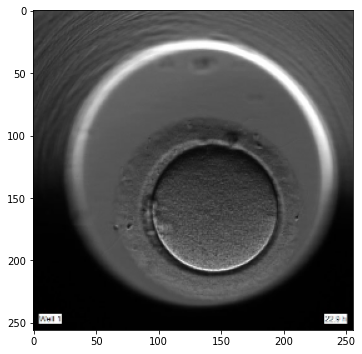

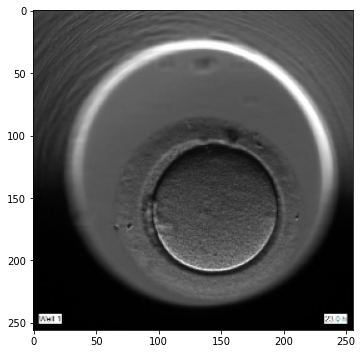

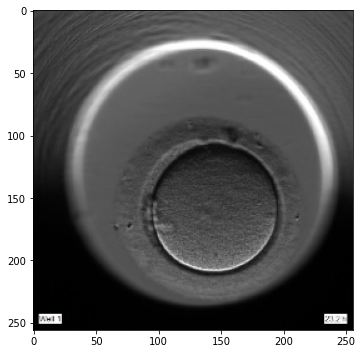

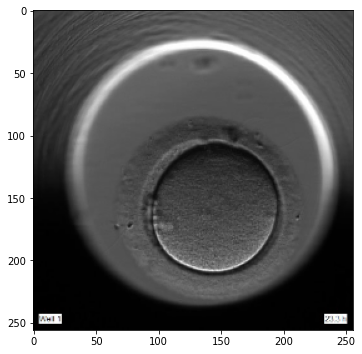

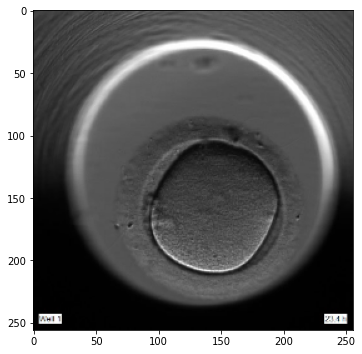

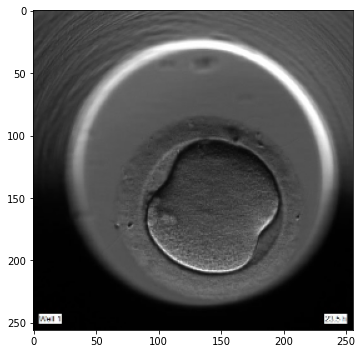

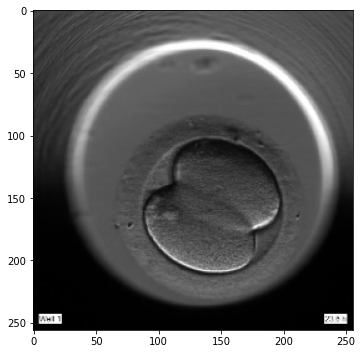

In [56]:
idx = random.randint(300,len(data))
idx=734
frames = return_frames(idx)
idx1 = random.randint(0,len(frames)-10)
idx1=15
frames = frames[idx1:idx1+10, :, :, :]
generate_images(frames)
for i in range(9):
  plt.figure(figsize=(20, 20))
  plt.subplot(3,3,i+1)
  expected =frames[i].astype(np.float32)
  plt.imshow(expected/255.0)


In [27]:
random_sample = random.sample(range(300, len(data)), 20)

In [28]:
len(random_sample)

20

In [30]:
validation_sample = list()
for i in random_sample:
  count = 0
  cap= cv2.VideoCapture(os.path.join(data_path,data[i]))
  temp = []
  while(cap.isOpened()):
    ret, frame = cap.read()
    count+=1
    try:
      img = cv2.resize(frame, (256,256))
      temp.append(img)
    except:
      break
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  count=0
  while(count+10 <= len(temp)):
    validation_sample.append(temp[count:count+10])
    count = count+10
  
  cap.release()
  cv2.destroyAllWindows()    


In [32]:
validation_frames = np.array(validation_sample)
print(validation_frames.shape)

(195, 10, 256, 256, 3)


In [33]:
def validation_testing(frames):
  expected = frames[-1]/255.0
  frames = frames[0:9, :, :, :]/255.0
  
  out = load_model.predict(np.expand_dims(frames, axis = 0))
  out = np.squeeze(out, axis = 0)
  out = np.expand_dims(out[-1, ...], axis = 0)
  out = tf.squeeze(out,axis = 0)
  expected = expected.astype(np.float32)
  
  mse,psnr = PSNR(expected*255,out*255)

  expected = expected.astype(np.float32)
  ssim = tf.image.ssim(expected, out, max_val=1, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
  return mse, psnr, ssim

In [40]:
TotalValidationMSE=0
TotalValidationPSNR=0
TotalValidationSSIM=0

for frame in validation_frames:
  mse,psnr,ssim = validation_testing(frame)
  TotalValidationMSE+=mse
  TotalValidationPSNR+=psnr
  TotalValidationSSIM+=ssim


print(f"Validation MSE : {TotalValidationMSE/len(validation_frames)}")
print(f"Validation PSNR: {TotalValidationPSNR/len(validation_frames)}")
print(f"Validation SSIM: {TotalValidationSSIM/len(validation_frames)}")


  

1/1 [==============================] - 13s 13s/step
Validation MSE : 37.38794787480281
Validation PSNR: 32.91088451146249
Validation SSIM: 0.9257696866989136


In [39]:
print(TotalValidationSSIM/20)

tf.Tensor(0.87658787, shape=(), dtype=float32)
